# This notebook takes the model created in Test-with-new-data notebook and deploys to Sagemaker

# Deploy a Keras or TensorFlow model trained anywhere using Amazon SageMaker


Amazon SageMaker makes it easier for any developer or data scientist to build, train, and deploy machine learning (ML) models. While it’s designed to alleviate the undifferentiated heavy lifting from the full life cycle of ML models, Amazon SageMaker’s capabilities can also be used independently of one another; that is, models trained in Amazon SageMaker can be optimized and deployed outside of Amazon SageMaker (or even out of the cloud on mobile or IoT devices at the edge). Conversely, Amazon SageMaker can deploy and host pre-trained models from model zoos, or other members of your team. 

In this blog post, we’ll demonstrate how to deploy a trained Keras (TensorFlow or MXNet backend) or TensorFlow model using Amazon SageMaker, taking advantage of Amazon SageMaker deployment capabilities, such as selecting the type and number of instances, performing A/B testing, and Auto Scaling.  Auto Scaling clusters are spread across multiple Availability Zones to deliver high performance and high availability.

Your trained model will need to be saved in either the Keras (JSON and weights hdf5) format or the TensorFlow Protobuf format. If you’d like to begin from a sample notebook that supports this blog post, [download it here](https://s3.amazonaws.com/aws-ml-blog/artifacts/keras-tensorflow-model-deployment/keras-tensorflow-model-deployment.ipynb).

For more on training the model on SageMaker and deploying, refer to https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/tensorflow_distributed_mnist/tensorflow_distributed_mnist.ipynb

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_file_path_list(path):  
    full_path_list = []
    for path, subdirs, files in os.walk(path):
        for filename in files:
            f = os.path.join(path, filename)
            full_path_list.append(f)
    return full_path_list

### Step 1. Set up

In the AWS Management Console, go to the Amazon SageMaker console. Choose Notebook Instances, and create a new notebook instance. Upload the current notebook and set the kernel to conda_tensorflow_p36.

The get_execution_role function retrieves the AWS Identity and Access Management (IAM) role you created at the time of creating your notebook instance.

In [2]:
import boto3, re
from sagemaker import get_execution_role

role = get_execution_role()

### Step 2. Load the Keras model using the json and weights file

If you saved your model in the TensorFlow ProtoBuf format, skip to "Step 4. Convert the TensorFlow model to an Amazon SageMaker-readable format.

In [3]:
import keras
from keras.models import model_from_json

Using TensorFlow backend.


Create a directory called keras_model, navigate to keras_model from the Jupyter notebook home, and upload the model.json and model-weights.h5 files (using the "Upload" menu on the Jupyter notebook home).

Navigate to keras_model from the Jupyter notebook home, and upload your model.json and model-weights.h5 files (using the "Upload" menu on the Jupyter notebook home). To use a sample model for this exercise [download and unzip the files found here](https://s3.amazonaws.com/aws-ml-blog/artifacts/keras-tensorflow-model-deployment/model.zip), then upload them to keras_model.

In [4]:
!ls keras_model

model.json  model-weights.h5


In [5]:
json_file = open('/home/ec2-user/SageMaker/keras_model/'+'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
loaded_model.load_weights('/home/ec2-user/SageMaker/keras_model/model-weights.h5')
print("Loaded model from disk")







Loaded model from disk


### Step 3. Export the Keras model to the TensorFlow ProtoBuf format

In [7]:
from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

In [8]:
# Note: This directory structure will need to be followed - see notes for the next section
model_version = '1'
export_dir = 'export/Servo/' + model_version

In [9]:
!rm -rf export/Servo/1/

In [10]:
# Build the Protocol Buffer SavedModel at 'export_dir'
builder = builder.SavedModelBuilder(export_dir)

In [11]:
# Create prediction signature to be used by TensorFlow Serving Predict API
signature = predict_signature_def(
    inputs={"inputs": loaded_model.input}, outputs={"score": loaded_model.output})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


In [12]:
from keras import backend as K

with K.get_session() as sess:
    # Save the meta graph and variables
    builder.add_meta_graph_and_variables(
        sess=sess, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
    builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: export/Servo/1/saved_model.pb


### Step 4. Convert TensorFlow model to a SageMaker readable format

Move the TensorFlow exported model into a directory export\Servo\. SageMaker will recognize this as a loadable TensorFlow model. Your directory and file structure should look like:

In [13]:
!ls export

Servo


In [14]:
!ls export/Servo

1


In [15]:
!ls export/Servo/1

saved_model.pb	variables


In [16]:
!ls export/Servo/1/variables

variables.data-00000-of-00001  variables.index


####  Tar the entire directory and upload to S3

In [17]:
import tarfile
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

In [18]:
import sagemaker

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

### Step 5. Deploy the trained model

The entry_point file "train.py" can be an empty Python file. The requirement will be removed at a later date.

In [19]:
!touch train.py

In [20]:
from sagemaker.tensorflow.model import TensorFlowModel
sagemaker_model = TensorFlowModel(model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                                  role = role,
                                  framework_version = '1.12',
                                  entry_point = 'train.py')

2.0.0 is the latest version of tensorflow that supports Python 2. Newer versions of tensorflow will only be available for Python 3.Please set the argument "py_version='py3'" to use the Python 3 tensorflow image.


In [21]:
%%time
predictor = sagemaker_model.deploy(initial_instance_count=1,
                                   instance_type='ml.m4.xlarge')

-------------!CPU times: user 822 ms, sys: 155 ms, total: 977 ms
Wall time: 6min 32s


Note: You will need to update the endpoint in the command below with the endpoint name from the output of the previous cell (INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-2018-09-28-14-26-05-826)

In [21]:
endpoint_name = 'sagemaker-tensorflow-2020-03-18-16-05-26-097'

In [22]:
import sagemaker
from sagemaker.tensorflow.model import TensorFlowModel
predictor=sagemaker.tensorflow.model.TensorFlowPredictor(endpoint_name, sagemaker_session)

### Step 6. Invoke the endpoint

## Invoke the SageMaker endpoint from the notebook

1
mxnet-mnist-byom/test_combined/2-9.jpg


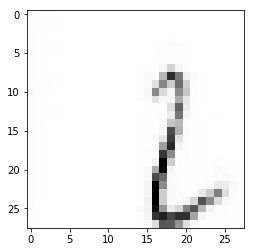

3
mxnet-mnist-byom/test_combined/8-1.jpg


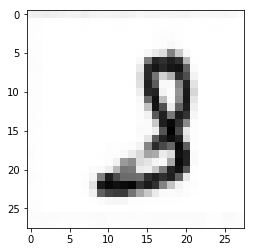

9
mxnet-mnist-byom/test_combined/4-9.jpg


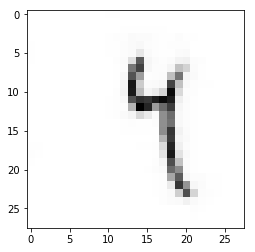

2
mxnet-mnist-byom/test_combined/7-7.jpg


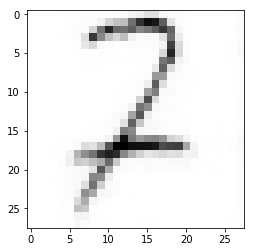

9
mxnet-mnist-byom/test_combined/4-13.jpg


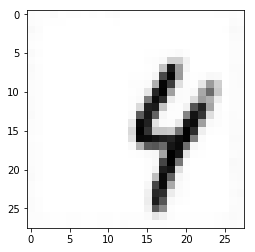

6
mxnet-mnist-byom/test_combined/2-10.jpg


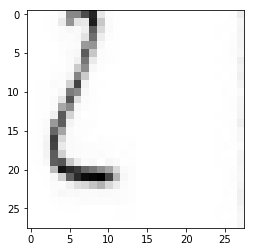

0
mxnet-mnist-byom/test_combined/6-12.jpg


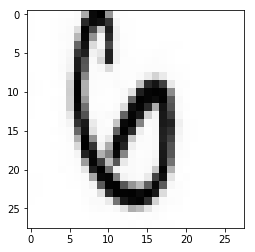

8
mxnet-mnist-byom/test_combined/3-3.jpg


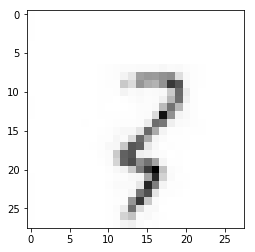

6
mxnet-mnist-byom/test_combined/5-9.jpg


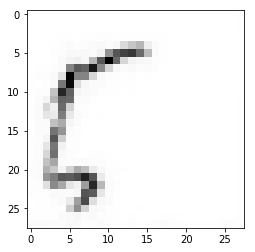

8
mxnet-mnist-byom/test_combined/0-7.jpg


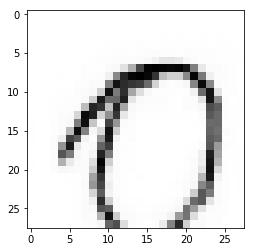

9
mxnet-mnist-byom/test_combined/8-0.jpg


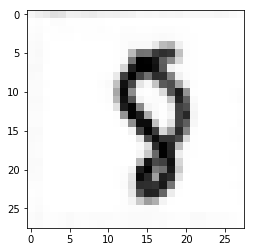

9
mxnet-mnist-byom/test_combined/4-8.jpg


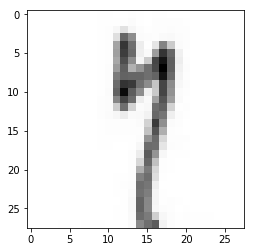

In [46]:
############################
image_files = get_file_path_list('mxnet-mnist-byom/test_combined')
correct = 0
for f in image_files:
    im_gray = cv2.imread(f)
    im_gray = cv2.cvtColor(im_gray, cv2.COLOR_BGR2GRAY)
#     im_gray = border(im_gray, 5) #########

    im_gray = im_gray/255
    dim = (28, 28)
    im_gray = cv2.resize(im_gray, dim, interpolation = cv2.INTER_AREA)
    im_gray = im_gray.astype('float32')

    im_gray =im_gray.reshape(1, 28, 28)
    pred = predictor.predict(im_gray.reshape(1, 784))
    pred = np.array(pred['outputs']['score']['float_val'])
    if pred.argmax()!= int(f.split('/')[-1].split('-')[0]):
#         correct+=1
        plt.figure()
        plt.imshow(im_gray.reshape(28, 28),cmap='Greys')
        print(pred.argmax())
        print(f)
        plt.show()
    if pred.argmax()== int(f.split('/')[-1].split('-')[0]):
        correct+=1
    
    

In [47]:
correct

141

# Invoke using Boto3

1
mxnet-mnist-byom/test_combined/2-9.jpg


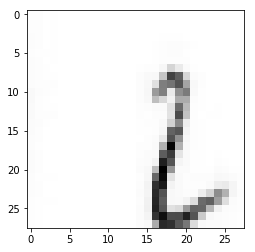

9
mxnet-mnist-byom/test_combined/4-9.jpg


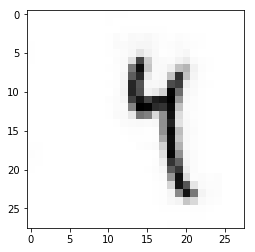

2
mxnet-mnist-byom/test_combined/7-7.jpg


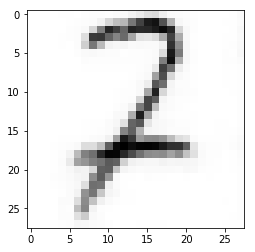

9
mxnet-mnist-byom/test_combined/4-13.jpg


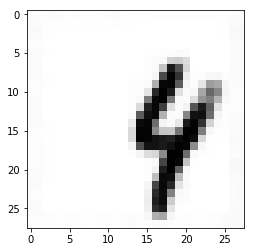

8
mxnet-mnist-byom/test_combined/0-6.jpg


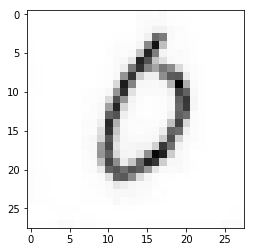

6
mxnet-mnist-byom/test_combined/2-10.jpg


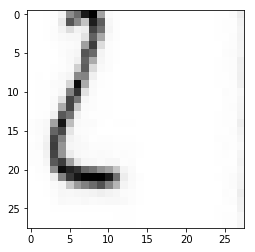

0
mxnet-mnist-byom/test_combined/6-12.jpg


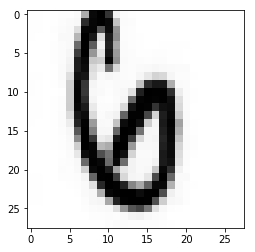

8
mxnet-mnist-byom/test_combined/3-3.jpg


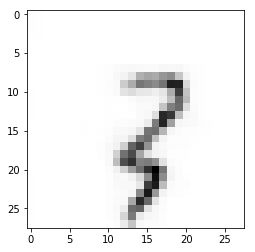

6
mxnet-mnist-byom/test_combined/5-9.jpg


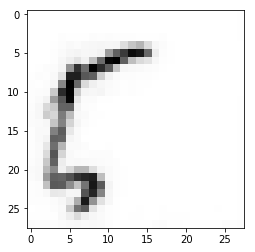

9
mxnet-mnist-byom/test_combined/8-0.jpg


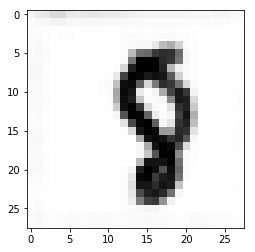

9
mxnet-mnist-byom/test_combined/4-8.jpg


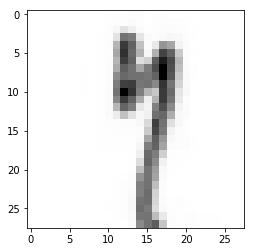

In [87]:
import json
import boto3
import numpy as np
import io
 
client = boto3.client('runtime.sagemaker')
############################
image_files = get_file_path_list('mxnet-mnist-byom/test_combined')
correct = 0
for f in image_files:
    im_gray = cv2.imread(f)
    im_gray = cv2.cvtColor(im_gray, cv2.COLOR_BGR2GRAY)
    im_gray = im_gray/255
    kernel = np.ones((2,2), np.uint8)
    im_gray = cv2.dilate(im_gray, kernel, iterations=1)
    dim = (28, 28)
    im_gray = cv2.resize(im_gray, dim, interpolation = cv2.INTER_AREA)
    im_gray = im_gray.astype('float32')

    im_gray =im_gray.reshape(1, 28, 28)
    im_graylist = im_gray.reshape(1, 784).tolist()  
    pred = client.invoke_endpoint(EndpointName=endpoint_name, Body=json.dumps(im_graylist))

    pred = json.loads(pred['Body'].read().decode("utf-8"))
    pred = np.array(pred['outputs']['score']['floatVal'])
    if pred.argmax()!= int(f.split('/')[-1].split('-')[0]):
    #         correct+=1
        plt.figure()
        plt.imshow(im_gray.reshape(28, 28),cmap='Greys')
        print(pred.argmax())
        print(f)
        plt.show()
    if pred.argmax()== int(f.split('/')[-1].split('-')[0]):
        correct+=1

In [81]:
correct/len(image_files)

0.9215686274509803

### Step 7. Clean up

To avoid incurring unnecessary charges, use the AWS Management Console to delete the resources that you created for this exercise:
https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html

### Conclusion

In this blog post, we demonstrated deploying a trained Keras or TensorFlow model at scale using Amazon SageMaker, independent of the computing resource used for model training. This gives you the flexibility to use your existing workflows for model training, while easily deploying the trained models to production with all the benefits offered by a managed platform. These benefits include the ability to select the optimal type and number of deployment instances, perform A/B testing, and auto scale. The Auto Scaling clusters of Amazon SageMaker ML instances can be spread across multiple Availability Zones to deliver both high performance and high availability.

### About the author

Dr. Priya Ponnapalli is a principal data scientist at Amazon ML Solutions Lab, where she helps AWS customers across different industries accelerate their AI and cloud adoption.